# 1. 导入依赖包

In [1]:
import pandas as pd
import numpy as np
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 2. 加载和预览数据

In [2]:
data = pd.read_csv("filtered_cnews.train.txt", sep="\t", header=None, names=["label", "text"])
data.head()

,label,text
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...


# 3. 分词处理（用 jieba）

In [3]:
# 加载停用词表
def load_stopwords(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        stopwords = set(line.strip() for line in f if line.strip())
    return stopwords
stopwords = load_stopwords("baidu_stopwords.txt")
# 分词 + 去停用词函数
def tokenize(text, stopwords):
    words = jieba.lcut(text)
    # 去掉停用词、空格和单个字符
    return " ".join([w for w in words if w not in stopwords and len(w.strip()) > 1])
# 在整个数据集上做分词处理
data["text_cut"] = data["text"].apply(lambda x: tokenize(x, stopwords))
print("原始文本：", data.iloc[0]["text"])
print("分词结果：", data.iloc[0]["text_cut"])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\32367\AppData\Local\Temp\jieba.cache
Loading model cost 1.574 seconds.
Prefix dict has been built successfully.


原始文本： 马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有摆脱雨水的困扰。7月31日下午6点，国奥队的日常训练再度受到大雨的干扰，无奈之下队员们只慢跑了25分钟就草草收场。31日上午10点，国奥队在奥体中心外场训练的时候，天就是阴沉沉的，气象预报显示当天下午沈阳就有大雨，但幸好队伍上午的训练并没有受到任何干扰。下午6点，当球队抵达训练场时，大雨已经下了几个小时，而且丝毫没有停下来的意思。抱着试一试的态度，球队开始了当天下午的例行训练，25分钟过去了，天气没有任何转好的迹象，为了保护球员们，国奥队决定中止当天的训练，全队立即返回酒店。在雨中训练对足球队来说并不是什么稀罕事，但在奥运会即将开始之前，全队变得“娇贵”了。在沈阳最后一周的训练，国奥队首先要保证现有的球员不再出现意外的伤病情况以免影响正式比赛，因此这一阶段控制训练受伤、控制感冒等疾病的出现被队伍放在了相当重要的位置。而抵达沈阳之后，中后卫冯萧霆就一直没有训练，冯萧霆是7月27日在长春患上了感冒，因此也没有参加29日跟塞尔维亚的热身赛。队伍介绍说，冯萧霆并没有出现发烧症状，但为了安全起见，这两天还是让他静养休息，等感冒彻底好了之后再恢复训练。由于有了冯萧霆这个例子，因此国奥队对雨中训练就显得特别谨慎，主要是担心球员们受凉而引发感冒，造成非战斗减员。而女足队员马晓旭在热身赛中受伤导致无缘奥运的前科，也让在沈阳的国奥队现在格外警惕，“训练中不断嘱咐队员们要注意动作，我们可不能再出这样的事情了。”一位工作人员表示。从长春到沈阳，雨水一路伴随着国奥队，“也邪了，我们走到哪儿雨就下到哪儿，在长春几次训练都被大雨给搅和了，没想到来沈阳又碰到这种事情。”一位国奥球员也对雨水的“青睐”有些不解。
分词结果： 马晓旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道 来到 沈阳 国奥队 依然 摆脱 雨水 困扰 31 下午 国奥队 日常 训练 再度 大雨 干扰 无奈 之下 队员 慢跑 25 分钟 草草收场 31 上午 10 国奥队 奥体中心 外场 训练 阴沉沉 气象预报 显示 当天 下午 沈阳 大雨 幸好 队伍 上午 训练 干扰 下午 球队 抵达 训练场 大雨 几个 小时 丝毫 停下来 试一试 态度 球队 当天 下午 例行 训练 25 分钟 天气 转好 迹

# 4. 划分训练/验证/测试集

In [4]:
X = data["text_cut"]
y = data["label"]
# 首先划分出训练集和临时集（验证集 + 测试集）
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 然后再从临时集中划分出验证集和测试集
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# 显示划分结果
print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_val)}")
print(f"测试集大小: {len(X_test)}")

训练集大小: 24000
验证集大小: 3000
测试集大小: 3000


# 5. 向量化（TF-IDF）

In [5]:
# 使用 TF-IDF 对文本数据进行向量化
vectorizer = TfidfVectorizer()
# 转换训练集、验证集、测试集
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print(f"训练集向量化后特征维度：{X_train.shape}")
print(f"验证集向量化后特征维度：{X_val.shape}")
print(f"测试集向量化后特征维度：{X_test.shape}")

训练集向量化后特征维度：(24000, 211763)
验证集向量化后特征维度：(3000, 211763)
测试集向量化后特征维度：(3000, 211763)


# 6. 模型训练与评估

In [10]:
plt.rcParams['font.family'] = 'SimHei'  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
def train_and_evaluate(model, model_name):
    print(f"正在训练模型：{model_name}")
    model.fit(X_train, y_train)
    # 测试集预测
    y_pred = model.predict(X_test)
    # 验证集预测
    y_val_pred = model.predict(X_val)
    # 验证集准确率
    val_acc = accuracy_score(y_val, y_val_pred)
    # 输出分类报告（测试集）
    print(f"{model_name} 分类报告（测试集）：")
    print(classification_report(y_test, y_pred, digits=4))
    # Micro / Macro 平均的 Precision、Recall、F1（使用官方函数手动算）
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_test, y_pred, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro'
    )
    print(f"micro avg - Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1-score: {f1_micro:.4f}")
    print(f"macro avg - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-score: {f1_macro:.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"验证集准确率：{val_acc:.4f}")
    # 混淆矩阵可视化
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} 混淆矩阵")
    plt.xticks(rotation=45)
    plt.show()
    # 返回 micro F1, macro F1, 验证集准确率
    return f1_micro, f1_macro, val_acc
# 记录每个模型的评估结果
results = []

## 6.1 模型1：朴素贝叶斯

正在训练模型：朴素贝叶斯 MultinomialNB
朴素贝叶斯 MultinomialNB 分类报告（测试集）：
              precision    recall  f1-score   support

          体育     0.9980    0.9980    0.9980       500
          家居     0.9849    0.9160    0.9492       500
          房产     0.8918    0.9560    0.9228       500
          教育     0.9255    0.9440    0.9347       500
          科技     0.9466    0.9580    0.9523       500
          财经     0.9565    0.9240    0.9400       500

    accuracy                         0.9493      3000
   macro avg     0.9506    0.9493    0.9495      3000
weighted avg     0.9506    0.9493    0.9495      3000

micro avg - Precision: 0.9493, Recall: 0.9493, F1-score: 0.9493
macro avg - Precision: 0.9506, Recall: 0.9493, F1-score: 0.9495
Accuracy: 0.9493
验证集准确率：0.9587


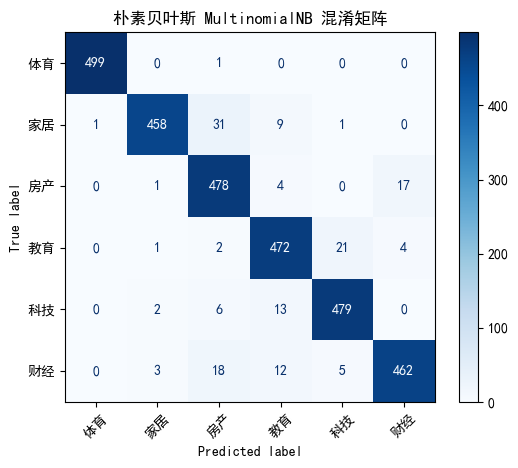

In [11]:
nb_model = MultinomialNB()
micro_f1_nb, macro_f1_nb, acc_nb = train_and_evaluate(nb_model, "朴素贝叶斯 MultinomialNB")
results.append(("MultinomialNB", micro_f1_nb, macro_f1_nb, acc_nb))

## 6.2 模型2：KNN

正在训练模型：K近邻 KNN
K近邻 KNN 分类报告（测试集）：
              precision    recall  f1-score   support

          体育     0.9708    0.9980    0.9842       500
          家居     0.9390    0.9540    0.9464       500
          房产     0.9533    0.9380    0.9456       500
          教育     0.9280    0.9020    0.9148       500
          科技     0.9435    0.9360    0.9398       500
          财经     0.9464    0.9540    0.9502       500

    accuracy                         0.9470      3000
   macro avg     0.9468    0.9470    0.9468      3000
weighted avg     0.9468    0.9470    0.9468      3000

micro avg - Precision: 0.9470, Recall: 0.9470, F1-score: 0.9470
macro avg - Precision: 0.9468, Recall: 0.9470, F1-score: 0.9468
Accuracy: 0.9470
验证集准确率：0.9480


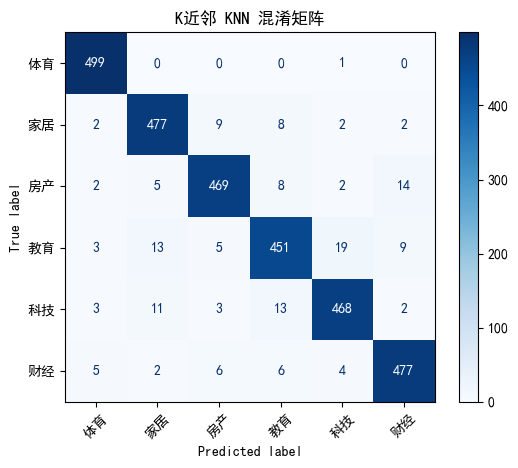

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=5)
f1_micro_knn, f1_macro_knn, acc_knn = train_and_evaluate(knn_model, "K近邻 KNN")
results.append(("KNN", f1_micro_knn, f1_macro_knn, acc_knn))

## 6.3 模型3：GBDT

正在训练模型：梯度提升树 GBDT
梯度提升树 GBDT 分类报告（测试集）：
              precision    recall  f1-score   support

          体育     0.9920    0.9960    0.9940       500
          家居     0.9057    0.9800    0.9414       500
          房产     0.9940    1.0000    0.9970       500
          教育     0.9597    0.9060    0.9321       500
          科技     0.9407    0.9200    0.9302       500
          财经     0.9655    0.9520    0.9587       500

    accuracy                         0.9590      3000
   macro avg     0.9596    0.9590    0.9589      3000
weighted avg     0.9596    0.9590    0.9589      3000

micro avg - Precision: 0.9590, Recall: 0.9590, F1-score: 0.9590
macro avg - Precision: 0.9596, Recall: 0.9590, F1-score: 0.9589
Accuracy: 0.9590
验证集准确率：0.9623


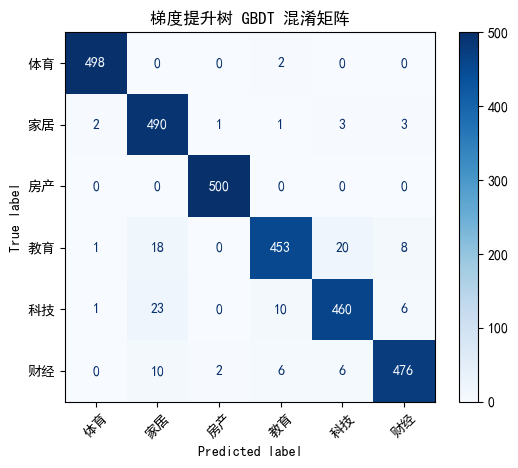

In [13]:
gbdt_model = GradientBoostingClassifier(
    n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42
)
f1_micro_gbdt, f1_macro_gbdt, acc_gbdt = train_and_evaluate(gbdt_model, "梯度提升树 GBDT")
results.append(("GBDT", f1_micro_gbdt, f1_macro_gbdt, acc_gbdt))

## 6.4 结果对比

In [14]:
df_results = pd.DataFrame(results, columns=["模型", "Micro F1", "Macro F1", "验证集准确率"])
print("模型评估对比：")
print(df_results)

模型评估对比：
              模型  Micro F1  Macro F1    验证集准确率
0  MultinomialNB  0.949333  0.949487  0.958667
1            KNN  0.947000  0.946830  0.948000
2           GBDT  0.959000  0.958911  0.962333
